In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# FEM box baseline evaluations

Objective is to evaluate the effect of element type, mesh alignment, PDE form and Savitsky-Golay filtering oon FEM baselines.

In [37]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx5000:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load MPI
source activate MRE-PINN

python ../../../fem.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name fem_box \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --pde_name {pde_name} \\
    --u_elem_type {u_elem_type} \\
    --mu_elem_type {mu_elem_type} \\
    --align_nodes {align_nodes} \\
    --savgol_filter {savgol_filter} \\
    --save_prefix {job_name}
'''
name = 'fem_{frequency}_{xyz_slice}_{pde_name}_{u_elem_type}_{mu_elem_type}_{align_nodes}_{savgol_filter}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[50, 60, 70, 80, 90, 100],
    xyz_slice=['2D'],
    pde_name=['helmholtz', 'hetero'],
    u_elem_type=['CG-1', 'CG-2'],
    mu_elem_type=['CG-1', 'DG-1', 'DG-0'],
    align_nodes=[1],
    savgol_filter=[0, 1]
)

len(param_space)

144

In [3]:
%autoreload
expt_name = '2022-09-09_FEM'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [4]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
10942729,fem_50_2D_helmholtz_CG-1_CG-1_1_0,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942730,fem_50_2D_helmholtz_CG-1_CG-1_1_1,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942731,fem_50_2D_helmholtz_CG-1_DG-1_1_0,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942732,fem_50_2D_helmholtz_CG-1_DG-1_1_1,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942733,fem_50_2D_helmholtz_CG-1_DG-0_1_0,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
...,...,...,...,...,...,...
10942868,fem_100_2D_hetero_CG-2_CG-1_1_1,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942869,fem_100_2D_hetero_CG-2_DG-1_1_0,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...
10942870,fem_100_2D_hetero_CG-2_DG-1_1_1,NaN,NaN,NaN,[240 rows x 3 columns],Lmod has detected the following error: The fol...


In [5]:
metrics = ps.metrics(jobs)

# did all models train to 25k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 0).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 0]

param_cols = ['frequency', 'pde_name', 'u_elem_type', 'mu_elem_type', 'align_nodes', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'mean_abs_value'] # metric values

var_name_level = len(param_cols) + index_cols.index('variable_name')
metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean().unstack(level=[var_name_level])

def metric_map(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'mean_abs_value': 'MAV',
        'power_density': 'SPD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

u_pred_MSAV  \
frequency pde_name  u_elem_type mu_elem_type align_nodes savgol_filter spatial_frequency_bin spatial_region                 
50        helmholtz CG-1        CG-1         1           0             all                   all             1.556485e-10   
                                                                                             0                        NaN   
                                                                                             1                        NaN   
                                                                                             2                        NaN   
                                                                                             3                        NaN   
...                                                                                                                   ...   
100       hetero    CG-2        DG-0         1           1             6.0                   all                      NaN   
                                                                       7.0                   all                      NaN   
                                                                       8.0                   all                      NaN   
                                                                       9.0                   all                      NaN   
                                                                       10.0                  all                      NaN   

                                                                                                              u_pred_MSAE  \
frequency pde_name  u_elem_type mu_elem_type align_nodes savgol_filter spatial_frequency_bin spatial_region                 
50        helmholtz CG-1        CG-1         1           0             all                   all             7.672853e-42   
                                                                                             0                        NaN   
                                                                                             1                        NaN   
                                                                                             2                        NaN   
                                                                                             3                        NaN   
...                                                                                                                   ...   
100       hetero    CG-2        DG-0         1           1             6.0                   all                      NaN   
                                                                       7.0                   all                      NaN   
                                                                       8.0                   all                      NaN   
                                                                       9.0                   all                      NaN   
                                                                       10.0                  all                      NaN   

                                                                                                              u_true_MSAV  \
frequency pde_name  u_elem_type mu_elem_type align_nodes savgol_filter spatial_frequency_bin spatial_region                 
50        helmholtz CG-1        CG-1         1           0             all                   all             1.556485e-10   
                                                                                             0                        NaN   
                                                                                             1                        NaN   
                                                                                             2                        NaN   
                                                                                             3              

<IPython.core.display.Javascript object>


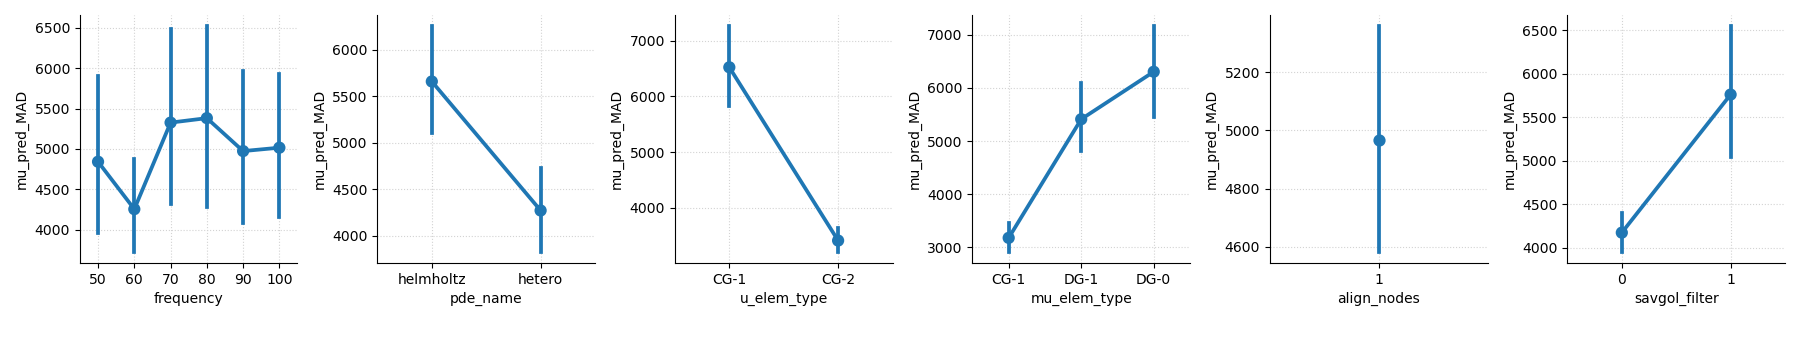

In [6]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['mu_pred_MAD'],
    hue=None,
    grouped=False,
    height=3.5, width=3,
    tight=True
)
#fig.savefig('1d_experiment_mu_pred_MAD.png', dpi=300, bbox_inches='tight')

There appear to be statistically significant signals from the choice of element type and whether or not we perform Savitzky-Golay filtering. However, we need to control for the other parameters before we draw any conclusions.

<IPython.core.display.Javascript object>


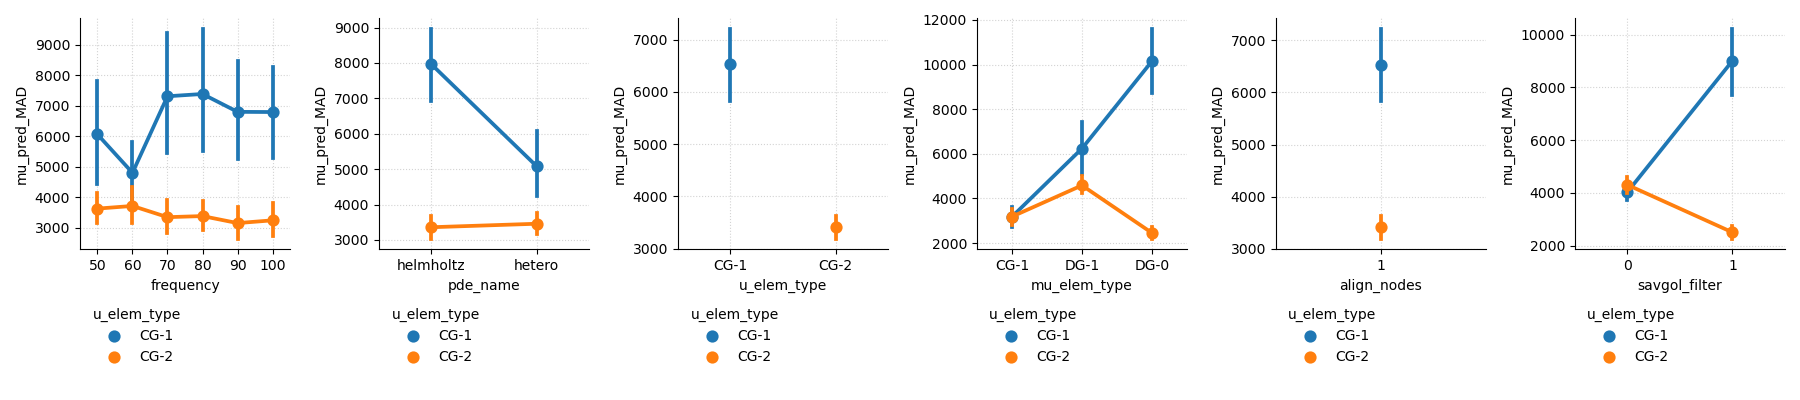

In [7]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['mu_pred_MAD'],
    hue='u_elem_type',
    grouped=False,
    height=4, width=3,
    tight=True
)

There appears to be a strong improvement from using second-order elements for the wave field instead first order elements. The use of second order elements also reverses the trends wrt the pde type and whether filtering is used, which is why it's important to control before drawing conclusions!

<IPython.core.display.Javascript object>


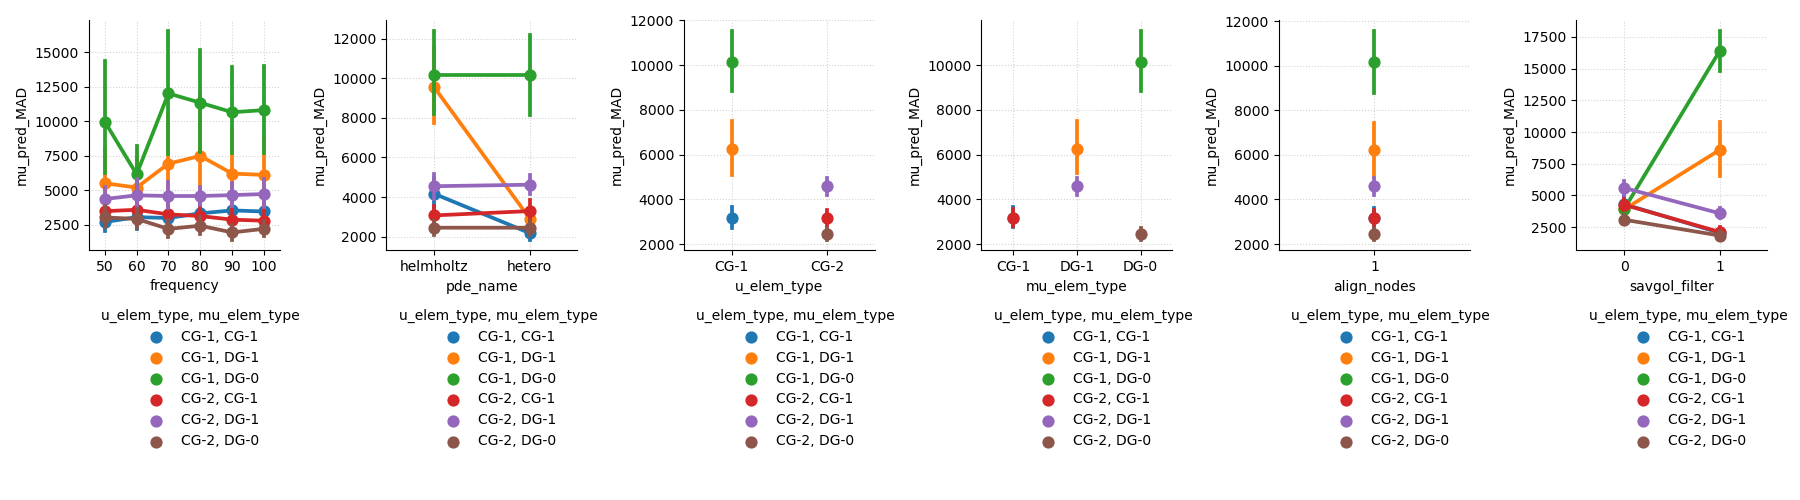

In [8]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['mu_pred_MAD'],
    hue=('u_elem_type', 'mu_elem_type'),
    grouped=False,
    height=5, width=3,
    tight=True
)

Now we control for both the wave field element type AND the elasticity element type. We see that second-order wave field elements are superior to first orer across both PDE types, with one exception being that the use of first order wave elements with first order DISCONTINUOUS elasticity elements seems to work OK specifically for the heterogeneous PDE. The best combination so far seems to be CG-2, DG-1, with the heterogeneous PDE.

In this figure we also see that Savitsky-Golay filtering improves the performance as long as we use second-order wave field elements.

In [13]:
metrics.groupby(
    ['u_elem_type', 'mu_elem_type', 'pde_name', 'savgol_filter']
)[['mu_pred_MAD']].mean().sort_values('mu_pred_MAD')

mu_pred_MAD
u_elem_type mu_elem_type pde_name  savgol_filter              
CG-2        DG-0         hetero    1               1830.920293
                         helmholtz 1               1830.920293
CG-1        DG-1         hetero    1               1974.858376
CG-2        CG-1         helmholtz 1               2033.319721
CG-1        CG-1         helmholtz 1               2048.327119
                         hetero    1               2049.668753
CG-2        CG-1         hetero    1               2186.032471
CG-1        CG-1         hetero    0               2316.015078
CG-2        DG-0         hetero    0               3078.021470
                         helmholtz 0               3078.084657
            DG-1         helmholtz 1               3111.804855
CG-1        DG-1         hetero    0               3860.234556
                         helmholtz 0               3911.584890
            DG-0         hetero    0               3911.694037
                         helmholtz 0               3911.694037
CG-2        DG-1         hetero    1               4057.822322
            CG-1         helmholtz 0               4115.942535
                         hetero    0               4402.763912
            DG-1         hetero    0               5191.913456
                         helmholtz 0               5987.842628
CG-1        CG-1         helmholtz 0               6292.162523
            DG-1         helmholtz 1              15200.156857
            DG-0         helmholtz 1              16397.280960
                         hetero    1              16397.280960